In [14]:
import matplotlib.pyplot as plt
from db.connection import q

In [15]:
sql = """
WITH account_trade_info AS (
	SELECT
		t.account_id,
		COUNT(*) AS trade_count, 
		SUM(t.commission) AS total_commission
	FROM "Trade" AS t
	WHERE t.deleted_at IS NULL
	GROUP BY t.account_id
), 
assets_current_price AS (
	SELECT DISTINCT ON (mp.asset_id)
		mp.asset_id,
		mp.price
	FROM "Market_Price" AS mp
	WHERE 
		mp.deleted_at IS NULL
	ORDER BY
		mp.asset_id,
		mp.price_at DESC
),
account_position_info AS (
	SELECT 
		p.account_id,
		SUM(
			p.quantity * assets_current_price.price
		) AS account_aum
	FROM "Position" AS p
	INNER JOIN assets_current_price
		ON assets_current_price.asset_id = p.asset_id
	WHERE p.deleted_at IS NULL
	GROUP BY
		p.account_id	
)
SELECT
	rp.name AS risk_profile,
	SUM(trade_info.total_commission) AS total_commission,
	SUM(trade_info.trade_count) AS total_trades,
	SUM(pos_info.account_aum) AS "total_aum"
FROM "Customer" AS c

INNER JOIN "Risk_Profile" AS rp
ON rp.id = c.risk_profile

INNER JOIN "Account" AS acc
ON acc.customer_id = c.id

LEFT JOIN account_trade_info AS trade_info
ON trade_info.account_id = acc.id

LEFT JOIN account_position_info AS pos_info
ON pos_info.account_id = acc.id

WHERE 
	c.deleted_at IS NULL
	AND
	acc.deleted_at IS NULL
GROUP BY
	c.risk_profile,
	rp.name
"""

In [16]:
df = q(sql)
df

,risk_profile,total_commission,total_trades,total_aum
0,conservative,935.3829,422.0,7.392577e+05
1,moderate,10474.1360,5064.0,3.705130e+06
2,aggressive,9430.0980,7263.0,9.582988e+05


In [17]:
df = df.set_index('risk_profile')
df

,total_commission,total_trades,total_aum
risk_profile,,,
conservative,935.3829,422.0,7.392577e+05
moderate,10474.1360,5064.0,3.705130e+06
aggressive,9430.0980,7263.0,9.582988e+05


In [18]:
total_by_profile_sql = """
    SELECT 
        rp.name AS risk_profile,
        COUNT(*)
    FROM "Customer" AS c
    INNER JOIN "Risk_Profile" AS rp
    ON rp.id = c.risk_profile
    WHERE 
        c.deleted_at IS NULL
    GROUP BY
        rp.name
"""

In [19]:
rp_total_info = q(total_by_profile_sql)
rp_total_info = rp_total_info.set_index(keys='risk_profile')

In [20]:
rp_total_info

,count
risk_profile,
aggressive,34
conservative,23
moderate,43


In [21]:
df = df.merge(rp_total_info, how='inner', left_index=True, right_index=True)
df

,total_commission,total_trades,total_aum,count
risk_profile,,,,
conservative,935.3829,422.0,7.392577e+05,23
moderate,10474.1360,5064.0,3.705130e+06,43
aggressive,9430.0980,7263.0,9.582988e+05,34


Normalize to get rid of bias due to the amount of customers per risk profile

In [22]:
df['count']

risk_profile
conservative    23
moderate        43
aggressive      34
Name: count, dtype: int64

In [23]:
df['total_trades']

risk_profile
conservative     422.0
moderate        5064.0
aggressive      7263.0
Name: total_trades, dtype: float64

**Normalized**

In [24]:
df_norm = df[['total_trades', 'total_commission', 'total_aum']].div(df['count'], axis=0)
df_norm

,total_trades,total_commission,total_aum
risk_profile,,,
conservative,18.347826,40.668822,32141.640800
moderate,117.767442,243.584558,86165.809260
aggressive,213.617647,277.355824,28185.260216


**Biased on amount of clients per risk profile**

In [25]:
df

,total_commission,total_trades,total_aum,count
risk_profile,,,,
conservative,935.3829,422.0,7.392577e+05,23
moderate,10474.1360,5064.0,3.705130e+06,43
aggressive,9430.0980,7263.0,9.582988e+05,34


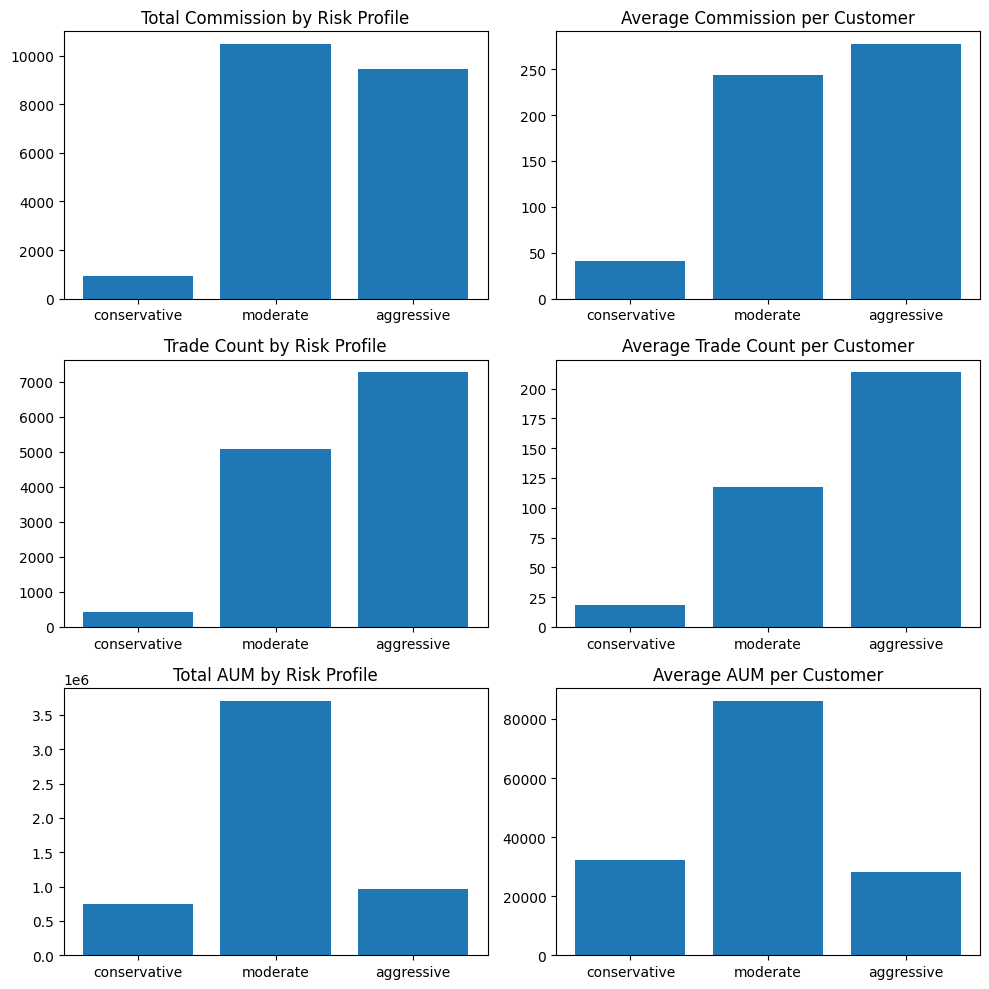

In [26]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
# Revenue comparison
axs[0][0].bar(df.index, df['total_commission'])
axs[0][0].set_title('Total Commission by Risk Profile')
axs[0][1].bar(df_norm.index, df_norm['total_commission'])
axs[0][1].set_title('Average Commission per Customer')

# Total trades comparison
axs[1][0].bar(df.index, df['total_trades'])
axs[1][0].set_title('Trade Count by Risk Profile')
axs[1][1].bar(df_norm.index, df_norm['total_trades'])
axs[1][1].set_title('Average Trade Count per Customer')

# AUM comparison
axs[2][0].bar(df.index, df['total_aum'])
axs[2][0].set_title('Total AUM by Risk Profile')
axs[2][1].bar(df_norm.index, df_norm['total_aum'])
axs[2][1].set_title('Average AUM per Customer')

plt.tight_layout()
plt.show()